In [2]:
import my_functions as mf
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

### *Voronoi Plotting*

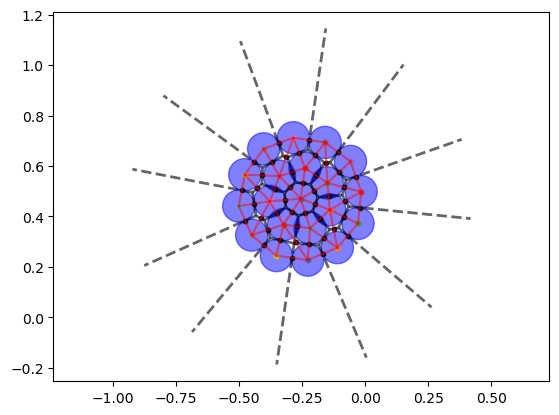

In [3]:
fig, axis = plt.subplots()
screen_size = np.array([-1, 1])

# Loads the steady state from the interaction_force
steady_state = mf.load_points("SteadyState2.txt")
r_cell = mf.get_cell_radius(beta=0.1)

# Generates the voronoi diagram and voronoi class
vor = Voronoi(steady_state)
voronoi_plot_2d(vor, axis, show_vertices=False, line_colors='black', line_width=2, line_alpha=0.6, point_size=0)

for i, point in enumerate(steady_state):
    # Plots circles
    circle = plt.Circle((point[0], point[1]), r_cell * 0.5, color = "blue", alpha = 0.5)
    axis.add_patch(circle)
    
    # Plots points
    axis.scatter(point[0], point[1], marker="o", s = 10, label = f"{i}")
    
# Plots the vertices    
#axis.scatter(vor.vertices[:, 0], vor.vertices[:, 1], marker="x", color = "black", label = "Vertices")

def plot_interaction_line(Voronoi_class, interaction, axis):
    """Plots both interaction line and center point between the two points"""
    point1, point2 = Voronoi_class.points[interaction[0]], Voronoi_class.points[interaction[1]]
    
    #Calcs center value
    center = (point1 + point2)/2
    
    # Plots the line
    axis.plot([point1[0], point2[0]], [point1[1], point2[1]], color = "red", alpha = 0.5)
    
    #Plots the center of the interaction line
    axis.scatter(center[0], center[1], marker="o", s = 10, color = "black", alpha = 0.8)
    
# Plots the interaction lines for All neighbours and center points
for interaction in vor.ridge_points:
    plot_interaction_line(vor, interaction, axis)

axis.set_xlim(screen_size)
axis.set_ylim(screen_size)
axis.axis("equal");

### *Line of sight*

In [4]:
### VORONOI CLASS ###
# this class contains the following attributes:
# - points: the input points (de punkter som jeg selv har givet)
# - vertices: Krydsningerne mellem linjerne i Voronoi plottet
# - ridge_points: en liste af punkter over de celler der deler en linje (alle interaktioner)

def check_line_of_sight(cell_index, neighbour_index, local_neighbours_index, points):
    """Finds the center between two points and checks in any of the neighbours in the local neighbours
       are closer to the center. 
       If Yes then the interaction is not a nearest neighbour.

    Returns:
        bool: True if the interaction is a nearest neighbour, False if not
    """
    # Calculate center point
    center = (points[cell_index] + points[neighbour_index])/2
    distance_from_cell = np.linalg.norm(center - points[cell_index])
    
    # Get distance from center to some of the other points
    # Vi looper igennem alle interaktioner med det indeks vi har fået og tjekker om nogle af de punkter
    # ligger tættere og dermed forstyrrer eye of sight af de andre punkter
    check = True
    for neighbour in local_neighbours_index:
        if neighbour == neighbour_index:
            break
        # Calcs distances between the two points
        distance_from_neighbour = np.linalg.norm(center - points[neighbour])

        # if a < b then the interaction is a nearest neighbour
        if distance_from_cell > distance_from_neighbour:
            check = False
    
    return check

### *Nearest Neighbours*

In [5]:
# Github kode for at udvælge naboer (FAST)
def get_interacting_neighbors(ridge_points, interaction_index):   
    """Checks all the ridge points in the Voronoi class and sorts the interacting neighbours for a given cell index
       Interacting just means that the two cells share a line

    Args:
        ridge_points (list): list of ridgepoints (should be in the form of Voronoi.ridge_points)
        interaction_index (int): The index of the cell we want to find the interacting neighbours for

    Returns:
        list: A list of all the interacting cell indices for a given cell index
    """
    # Convert ridge_points to NumPy array for faster computations
    ridge_points = np.array(ridge_points)
    
    # Find interactions involving the given point index
    # Looper igennem alle punkter og tjekker om indexet vi fokuserer på er i listen som det første element eller det andet
    interactions = ridge_points[np.logical_or(ridge_points[:, 0] == interaction_index, ridge_points[:, 1] == interaction_index)]
    
    # Fjerner indexet fra interaktionerne så vi kun har naboerne i en liste
    # [[1,2], [1,3], [1,4]] -> [2,3,4]
    interactions = interactions[interactions != interaction_index]
    
    return np.array(interactions)


def get_nearest_neighbours(Voronoi_class):
    """Gets the neighbours of all points and checks if the neighbours are classified as "nearest neighbours"
    according with Maja's definition. (b > a).
    By Nearest we mean that the two cells are closer to each other than to any other cell."""
    All_nearest_neighbours = []
    
    # All neighbours which just means those points that share a line
    all_interactions = Voronoi_class.ridge_points
    points = Voronoi_class.points
    
    # Loops through all the points, gets the corresponding neighbours and checks if those neighbours are considered nearest
    for index in range(len(points)):
        local_nearest_neighbours = []
        local_neighbours_index = get_interacting_neighbors(all_interactions, index)

    # Checks if the interaction is a nearest neighbour
        for neighbour in local_neighbours_index:
            is_nearest_neighbour = check_line_of_sight(index, neighbour, local_neighbours_index, points)
        
            # Adds the nearest neighbours to the list
            if is_nearest_neighbour:
                local_nearest_neighbours.append(neighbour)

        All_nearest_neighbours.append(local_nearest_neighbours)
    # Eventually we need to return more than just the neighbours (maybe points)
    return All_nearest_neighbours

In [6]:
# Yep its working
neighbours = get_nearest_neighbours(vor)
for i, neighbour in enumerate(neighbours):
    print(f"Neighbours for cell {i}: {neighbour}")

Neighbours for cell 0: [9, 1, 5, 6, 3, 2, 4]
Neighbours for cell 1: [9, 12, 11, 0, 13, 2]
Neighbours for cell 2: [14, 1, 13, 3, 15, 0]
Neighbours for cell 3: [15, 16, 2, 4, 0]
Neighbours for cell 4: [18, 17, 6, 3, 16, 0]
Neighbours for cell 5: [10, 9, 7, 8, 0, 6]
Neighbours for cell 6: [18, 7, 5, 0, 4, 19]
Neighbours for cell 7: [8, 5, 6, 19]
Neighbours for cell 8: [10, 7, 5]
Neighbours for cell 9: [10, 5, 0, 11, 1]
Neighbours for cell 10: [9, 8, 11]
Neighbours for cell 11: [10, 9, 12, 1]
Neighbours for cell 12: [13, 11, 1]
Neighbours for cell 13: [12, 14, 1, 2]
Neighbours for cell 14: [13, 15, 2]
Neighbours for cell 15: [14, 3, 16, 2]
Neighbours for cell 16: [17, 3, 15, 4]
Neighbours for cell 17: [18, 16, 4]
Neighbours for cell 18: [6, 19, 4, 17]
Neighbours for cell 19: [18, 7, 6]
